In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import pandas as pd
import yaml
from omegaconf import OmegaConf
from taming.models.cond_transformer import Net2NetTransformer


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [2]:
# Prepare CelebAHQ configurations
config_path = fr"C:\Users\DripTooHard\PycharmProjects\taming-transformers2\configs\faceshq_transformer.yaml"
celebAHQ_config = OmegaConf.load(config_path)
print(yaml.dump(OmegaConf.to_container(celebAHQ_config)))

# Init model with the chosen architecture and configurations
VQGAN_model = Net2NetTransformer(**celebAHQ_config.model.params)

#Load checkpoints
ckpt_path = r"C:\Users\DripTooHard\PycharmProjects\taming-transformers2\configs\faceshq.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
VQGAN_model.load_state_dict(sd)
missing, unexpected = VQGAN_model.load_state_dict(sd, strict=False)

#Put model in evaluation mode
VQGAN_model.eval()
torch.set_grad_enabled(False)

data:
  params:
    batch_size: 2
    num_workers: 8
    train:
      params:
        coord: true
        crop_size: 256
        size: 256
      target: taming.data.faceshq.FacesHQTrain
    validation:
      params:
        coord: true
        crop_size: 256
        size: 256
      target: taming.data.faceshq.FacesHQValidation
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        down_factor: 16
        n_embed: 1024
      target: taming.modules.misc.coord.CoordStage
    cond_stage_key: coord
    first_stage_config:
      params:
        ckpt_path: C:\Users\DripTooHard\PycharmProjects\taming-transformers2\configs\faceshq.ckpt
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 3
          num_res_blocks: 2
          out_ch: 3
  

In [3]:
# Load the dataset from HuggingFace
dataset = load_dataset("mattymchen/celeba-hq")

# Convert the dataset to a pandas DataFrame
images_df = pd.DataFrame(dataset["validation"])



# Display the first few rows of the DataFrame
print(images_df.head())


                                               image  label
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0


In [4]:
#load dataset and gender prediction model
gender_model = models.resnet18(pretrained=True)
num_features = gender_model.fc.in_features
gender_model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)

# Load the model state dict with mapping to CPU
gender_model.load_state_dict(torch.load(r"C:\Users\DripTooHard\PycharmProjects\taming-transformers2\scripts\Trident\face_gender_classification_transfer_learning_with_ResNet18.pth", map_location=device))
model = gender_model.to(device)
model.eval()
model.float()

C:\Users\DripTooHard\PycharmProjects\taming-transformers2\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DripTooHard\PycharmProjects\taming-transformers2\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
def get_image_4torch(image_df,idx):
    return torch.tensor(np.array(image_df["image"].iloc[idx]),dtype=torch.float32).permute(2,0,1).unsqueeze(0)

def deconstruct_reconstruct(VQGAN_model,image):
    VQGAN_model.d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)
Time per image: 1701811906.1604278


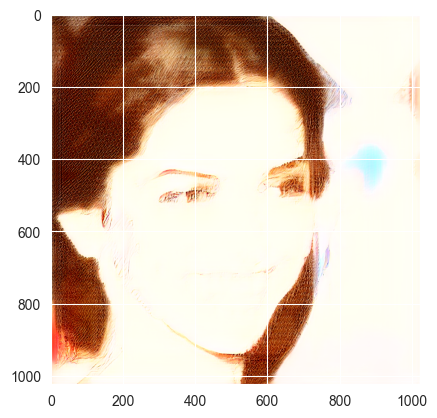

In [9]:
import time
start = time.time()
n = 0
test_image = get_image_4torch(images_df,n)
quant_z, indices = VQGAN_model.encode_to_z(test_image)
recon = VQGAN_model.decode_to_img(indices,quant_z.shape)
prediction = gender_model(recon)
print(torch.argmax(prediction))
plt.imshow(recon[0].permute(1,2,0))
print(f"Time per image: {time.time()}")